# Analizando datos del covid19 con Python

## Introducción

Fuente: https://pomber.github.io/covid19/timeseries.json

Advertencia: Nada de esto es científico, no me dedico a nada que tenga que ver con salud, aunque tengo estudios en el área hace ya más de 1 década que no hago nada que tenga que ver ni parcialmente con ello, así que simplemente es un proceso de auto complacencia para tratar de ver los números que están disponibles, todo lo que digo es mi opinión, y seguro estoy comentiendo errores de análisis, de código y de juicio. Los datos siempre van un día atrasados porque la fuente así se actualiza.

Es probable que vaya actualizando mis opiniones y el código, gráficas, etc. Pero de ninguna manera es algo que esté haciendo de manera profesional o seria, si sirve de algo me daría mucho gusto, por el momento solo sirve para darme idea de cómo va México en el proceso, y espero que las decisiones que se han ido tomando nos mantengan entre los países con menores daños en esta epidemia, la primera fuerte que vive mi generación ! esto va a ser algo para recordar. Hemos tenido diversas enfermedados en las últimas décadas que han dado problemas serios (SIDA, SARS, Ébola, MERS, y seguro otras que no recuerdo en este momento), pero creo que el covid19 va a pasar a la historia como la peor de esta época, una epidema de las que se dan cada 100 años o incluso con menor frecuencia.

Sobre el código, tratando de sacarle provecho a todo lo posible (en las bibliotecas de python) para hacer el análisis más sencillo (menos código) uso en la mayor parte de las gráficas las herramientas de Pandas, y trato de no usar demasiado matplotlib por fuera, claro que no es posible al 100% ni cerca, pero intento. 

Lo que sigue es un montón de imports de las herramientas más populares de analisis y graficado de datos:

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests as r
import matplotlib.dates as mdates
import time
from IPython.display import clear_output
from time import sleep
from scipy.optimize import curve_fit
import statsmodels.api as sm
import matplotlib.colors as mcolors

# Descargando la fuente de datos

`requests` es una de las bibliotecas más fáciles de usar para interaccionar con sitios web de manera genérica o para recolectar datos (APIs, JSON, Tablas, etc.).

In [2]:
data = r.get("https://pomber.github.io/covid19/timeseries.json")
#data.json()

## Países en el archivo

In [3]:
print("{} países registrados con al menos 1 caso confirmado:\n".format(len(data.json().keys())))

for i in data.json().keys():
    print("{}, ".format(i), end="")

177 países registrados con al menos 1 caso confirmado:

Afghanistan, Albania, Algeria, Andorra, Angola, Antigua and Barbuda, Argentina, Armenia, Australia, Austria, Azerbaijan, Bahamas, Bahrain, Bangladesh, Barbados, Belarus, Belgium, Benin, Bhutan, Bolivia, Bosnia and Herzegovina, Brazil, Brunei, Bulgaria, Burkina Faso, Cabo Verde, Cambodia, Cameroon, Canada, Central African Republic, Chad, Chile, China, Colombia, Congo (Brazzaville), Congo (Kinshasa), Costa Rica, Cote d'Ivoire, Croatia, Diamond Princess, Cuba, Cyprus, Czechia, Denmark, Djibouti, Dominican Republic, Ecuador, Egypt, El Salvador, Equatorial Guinea, Eritrea, Estonia, Eswatini, Ethiopia, Fiji, Finland, France, Gabon, Gambia, Georgia, Germany, Ghana, Greece, Guatemala, Guinea, Guyana, Haiti, Holy See, Honduras, Hungary, Iceland, India, Indonesia, Iran, Iraq, Ireland, Israel, Italy, Jamaica, Japan, Jordan, Kazakhstan, Kenya, Korea, South, Kuwait, Kyrgyzstan, Latvia, Lebanon, Liberia, Liechtenstein, Lithuania, Luxembourg, Ma

## Copiando los datos a un Data Frame para facilidad de manejo
Se guarda un diccionario de datos con los datos de cada país en forma de DataFrame y se hace un diccionario del total de casos para cada día registrado en la fuente:

In [4]:
total = {}
country = {}
for k in data.json().keys():
    #print(k)
    country[k] = pd.DataFrame.from_dict(data.json()[k], )
    country[k]['date'] = pd.to_datetime(country[k]['date'])
    country[k].index = country[k]['date'] 
    del country[k]['date'] 
    for item in data.json()[k]:
        if item['date'] in total:
            total[item['date']] += item['confirmed']
        else:
            total[item['date']] = item['confirmed']
print(total)

{'2020-1-22': 555, '2020-1-23': 654, '2020-1-24': 941, '2020-1-25': 1434, '2020-1-26': 2118, '2020-1-27': 2927, '2020-1-28': 5578, '2020-1-29': 6166, '2020-1-30': 8234, '2020-1-31': 9927, '2020-2-1': 12038, '2020-2-2': 16787, '2020-2-3': 19881, '2020-2-4': 23892, '2020-2-5': 27635, '2020-2-6': 30794, '2020-2-7': 34391, '2020-2-8': 37120, '2020-2-9': 40150, '2020-2-10': 42762, '2020-2-11': 44802, '2020-2-12': 45221, '2020-2-13': 60368, '2020-2-14': 66885, '2020-2-15': 69030, '2020-2-16': 71224, '2020-2-17': 73258, '2020-2-18': 75136, '2020-2-19': 75639, '2020-2-20': 76197, '2020-2-21': 76819, '2020-2-22': 78572, '2020-2-23': 78958, '2020-2-24': 79561, '2020-2-25': 80406, '2020-2-26': 81388, '2020-2-27': 82746, '2020-2-28': 84112, '2020-2-29': 86011, '2020-3-1': 88369, '2020-3-2': 90306, '2020-3-3': 92840, '2020-3-4': 95120, '2020-3-5': 97886, '2020-3-6': 101801, '2020-3-7': 105847, '2020-3-8': 109821, '2020-3-9': 113590, '2020-3-10': 118620, '2020-3-11': 125875, '2020-3-12': 128352, '20

El arreglo de datos totales se pasa a DataFrame también y se agregan un par de columnas utilitarias que nos ayudarán a trabajar con ajustes en las siguientes celdas. Adelantando un poco de información, las fechas no son buenos datos para usar en un ajuste, el tiempo lo es, pero usar el epoch (número de segudos desde 1970-01-01 hasta el momento deseado) nos da números de magnitudes enormes que no son fáciles de manejar en algunos tipos de ajustes, particularmente los de crecimiento exponencial, por lo que podemos hacer una pequeña transformación de segundos a días y con eso tener números mucho más pequeños y fáciles de visualizar y manejar.

In [5]:
total_df = pd.DataFrame.from_dict(total, orient="index", columns=['confirmed'])
total_df.index = pd.to_datetime(total_df.index)
min_sec = time.mktime(total_df.index.min().timetuple())
total_df['seconds'] = [time.mktime(t.timetuple()) - min_sec for t in total_df.index]
total_df['days'] = total_df['seconds'] / 86400
total_df.head() # Ver la forma del DF

,confirmed,seconds,days
2020-01-22,555,0.0,0.0
2020-01-23,654,86400.0,1.0
2020-01-24,941,172800.0,2.0
2020-01-25,1434,259200.0,3.0
2020-01-26,2118,345600.0,4.0


# Números totales

Esta es la evolución de los datos globales (22 de enero 2020 a la fecha) con un ajuste de crecimiento exponencial sobrepuesto hecho con la API de `statsmodels`.

## Ajuste exponencial
Los ajustes usan la columna de día como abscisa (x) tomando como día cero en 2020-01-22 que es el inicio de los datos.

In [6]:
# Definir datos a ajustar con statsmodels.OLS
x_range = total_df.days
y_range = np.log(total_df["confirmed"]) # Log del exponencial para hacer un ajuste lineal
# Los ingresamos al ajustador de mínimos cuadrados
X = sm.add_constant(x_range)
y = y_range
mods = sm.OLS(y, X)
res = mods.fit()

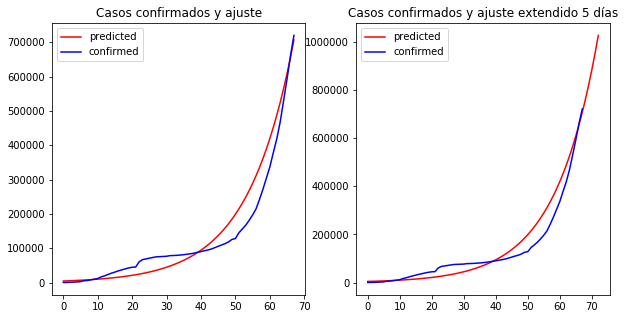

In [7]:
# Extraer parámetros resultantes y  sustituírlos adecuadamente
a, b = res.params
y = lambda x: np.exp(a) * np.exp(b) ** x # Usamos lambdas !
x_predicted = np.linspace(total_df.days.min(), total_df.days.max(), len(total_df.days))
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(x_predicted, y(x_predicted), 'r-', label="predicted")
ax[0].plot(total_df.days, total_df['confirmed'], 'b-', label="confirmed")
# Predicción con 5 días en el futuro
x_predicted = np.linspace(total_df.days.min(), total_df.days.max()+5, len(total_df.days))
ax[1].plot(x_predicted, y(x_predicted), 'r-', label="predicted")
ax[1].plot(total_df.days, total_df['confirmed'], 'b-', label="confirmed")
# Títulos
ax[0].set_title("Casos confirmados y ajuste")
ax[1].set_title("Casos confirmados y ajuste extendido 5 días")
# Fix labels
for ax in fig.axes:
    plt.sca(ax)
    #plt.xticks(rotation=45)
    plt.legend()


Esta es una de las primeras gráficas que quería ver, de hecho con esto inicié el notebook, y rápidamente me di cuenta que aunque estamos en una buena etapa para ajustar los datos con una ecuación simple de crecimiento exponencial, es obvio que hay mucho ruido tanto de las fuentes de datos como del comportamiento no ideal del bicho. 

La segunda gráfica es la predicción con 5 días en el futuro, la empecé a ver cuando el número de casos era de unos 300 mil creo, llegar al millón se veía a un par de semanas, ahora ya se ve a menos de 1 semana (empecé esto por ahí del 22 de marzon según recuerdo). Aunque el ajuste no es realmente muy bueno, la predicción a 5 días es bastante acertada a ojo de buen cubero.

La siguiente gráfica es "la derivada numérica de los datos", en otras palabras la diferencia de casos confirmados entre cada día.

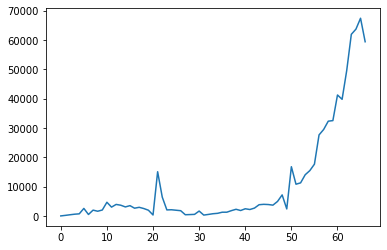

In [8]:
plt.plot(np.diff(total_df.confirmed))

El pico al rededor del día 20 lo explican como una corrección (o cambio) del método de detección del virus en China, me parece que algo similar pasó por el día 50, pero no estoy seguro de eso. Después del día 50 creo que podemos decir que la epidemia ya está comprobada, el número de casos nuevos cada día es enorme, estamos llegando a los 70 mil diarios (2020-03-29)


## Ajuste polinomial
Esta es la segunda gráfica que hice al darme cuenta que los números no se ajustan de manera "maravillosa" a la exponencial. 

Decidí hacer un ajuste simple polinomial (NumPy al rescate) que obviamente se ve mucho mejor en general, pero no solo eso, a simple vista se puede ver que su predicción es probablemente más acertada también (planeo probar eso en los siguientes días haciendo ajustes obre los datos parciales y viendo cómo reproducen "el futuro" digamos de 1 o 2 semanas (las últimas registradas).

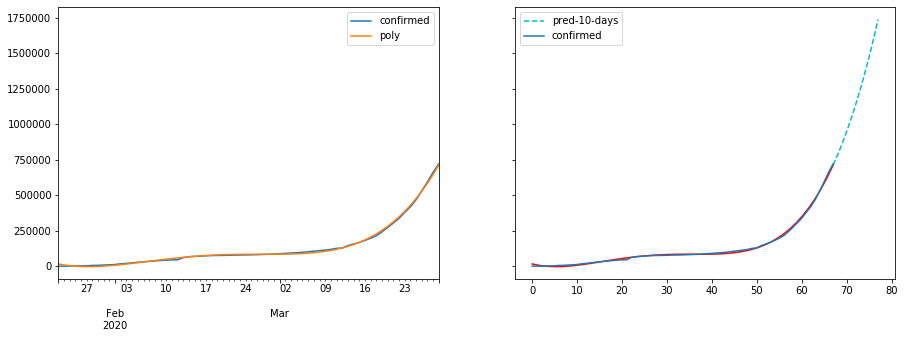

In [9]:
p = np.polyfit(total_df["days"].array, total_df["confirmed"].array,4) # 4to grado
x = np.linspace(total_df.days.min(), total_df.days.max(),50)
f = np.poly1d(p)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,5))

total_df['poly'] = f(total_df.days) #Agregando el ajuste al DF
total_df.plot( y=["confirmed", "poly"], fig=fig, ax = ax1)
x = np.linspace(total_df.days.min(), total_df.days.max(),50)
ax2.plot(x, f(x), 'r-')
x = np.linspace(total_df.days.max(), total_df.days.max()+10,10)
ax2.plot(x, f(x), 'c--', label='pred-10-days')
ax2.plot(range(total_df["confirmed"].count()), total_df["confirmed"], label='confirmed')
leg = ax2.legend()

El polinomio "le pega" bastante bien a los números (der.)(recordar que son una aproximación también, debe haber una cantidad importante de casos no detectados), y la predicción (izq.) se ve bastante creíble, más que la del ajuste exponencial :). Dentro de la siguiente semana estaremos sin duda arriba del millón de casos confirmados y en menos de 10 días habremos duplicado el número de casos actuales.

## Países con más casos

Ahora vamos a expulgar un poco más, tomamos el registro más reciente de cada país filtrando los que tienen más de `min_confirmed` casos confirmados para tener el total de cada país:

In [10]:
min_confirmed = 1000
day = country['Mexico'].index[-1].strftime("%Y-%m-%d") # Last day for any of the countries
print(day)
country_day = {}
for k in data.json().keys():
    country_day[k] =  country[k].loc[day]#["confirmed"]

2020-03-29


Pasamos el diccionario a un DataFrame para graficar fácilmente los datos (vamos a usar ese truco casi en todos los casos):

In [11]:
country_day = pd.DataFrame.from_dict(country_day, orient='index', columns=["confirmed", "recovered", "deaths"])

In [12]:
country_day.head()

,confirmed,recovered,deaths
Afghanistan,120,2,4
Albania,212,33,10
Algeria,511,31,31
Andorra,334,1,6
Angola,7,0,2


In [13]:
country_day.sort_values("confirmed", ascending=False).head(20)

,confirmed,recovered,deaths
US,140886,2665,2467
Italy,97689,13030,10779
China,82122,75582,3304
Spain,80110,14709,6803
Germany,62095,9211,533
France,40708,7226,2611
Iran,38309,12391,2640
United Kingdom,19780,151,1231
Switzerland,14829,1595,300
Netherlands,10930,253,772


In [14]:
country_day.sum()

confirmed    720117
recovered    149082
deaths        33925
dtype: int64

## Número de países con muchos casos (*más* de `min_confirmed` casos confirmados):

Y su distribución por porcentajes, disculpen el traslape de etiquetas:

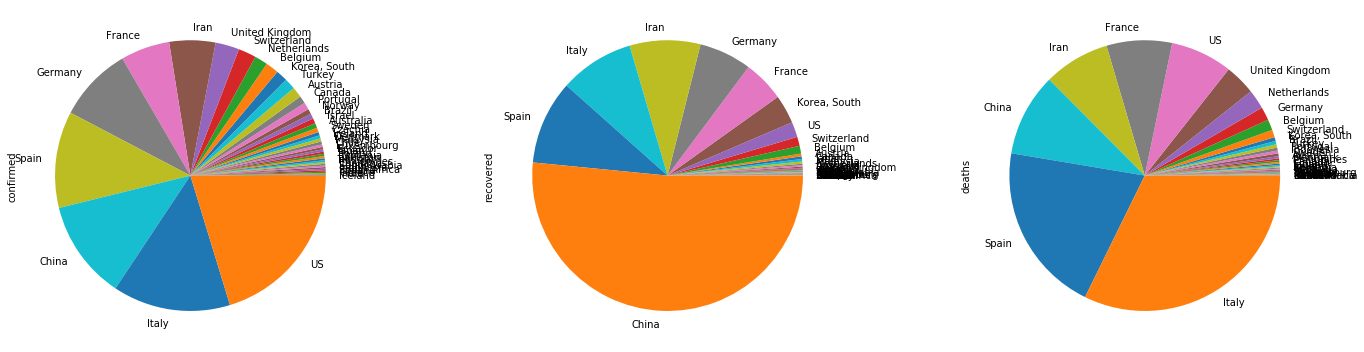

In [16]:
fig, ax = plt.subplots(1,3, figsize=(20,5))
country_day_top = country_day[country_day['confirmed'] > min_confirmed]
country_day_top['confirmed'].sort_values().plot(kind='pie', ax = ax[0])#, figsize=(15,15))
country_day_top['recovered'].sort_values().plot(kind='pie', ax = ax[1])#, figsize=(15,15))
country_day_top['deaths'].sort_values().plot(kind='pie', ax = ax[2])#, figsize=(15,15))
plt.tight_layout()

In [17]:
country_day_top["confirmed"].count()

42

## Número de países con pocos casos (*menos* de `min_confirmed` casos confirmados):

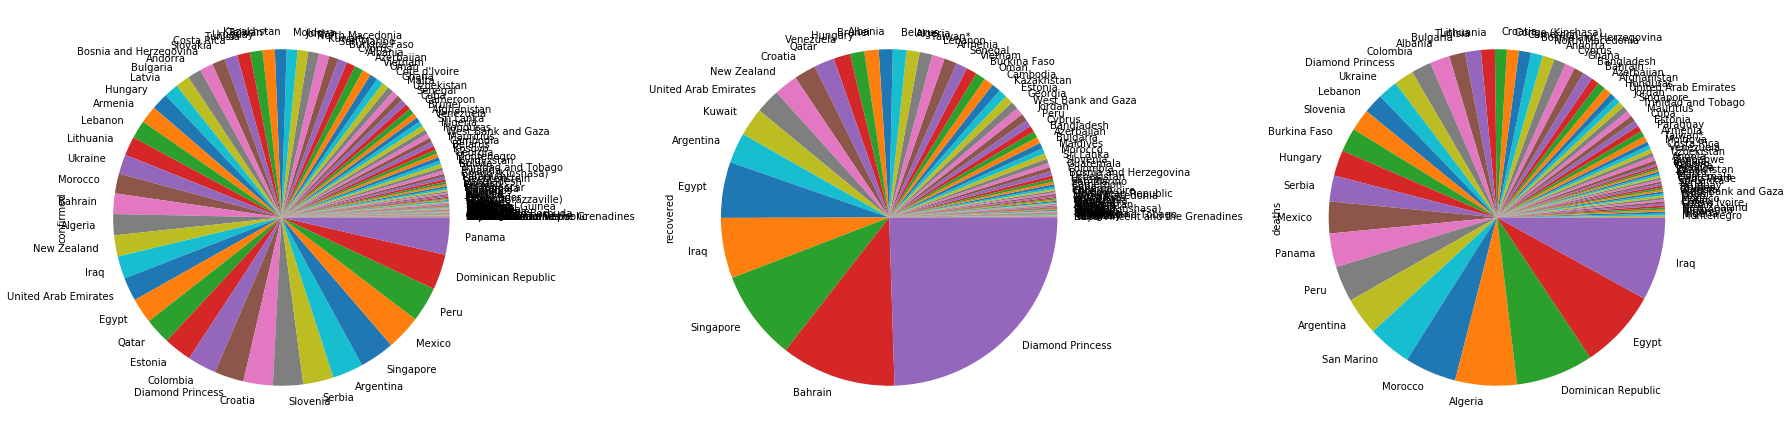

In [19]:
fig, ax = plt.subplots(1,3, figsize=(25,10))
country_day_bottom = country_day[country_day['confirmed'] < min_confirmed]
country_day_bottom['confirmed'].sort_values().plot(kind='pie', ax = ax[0])
country_day_bottom['recovered'].sort_values().plot(kind='pie', ax = ax[1])
country_day_bottom['deaths'].sort_values().plot(kind='pie', ax = ax[2])
plt.tight_layout()

In [20]:
country_day_bottom["confirmed"].count()

135

La distribución de casos confirmados es bastante uniforme, pero no las de casos recuperados y la de defunciones. El caso de defunciones de Iraq salta a la vista (2020-03-29), no está cerca de los que más casos confirmados tienen (en este filtrado) pero está en primer lugar de defunciones.

## Distribución en histograma de número de países por número de casos
La distribución está muy centrada en valores por debajo de 1000 casos (ver tercer histograma, solo hay menos de 10 países que claramente entraron en una fase avanzada de casos. He visto comentarios de que se estima que podría infectarse el 70% de la población, por lo que deberíamos esperar que esa distribución se haga mucho más amplia con el paso de los meses.

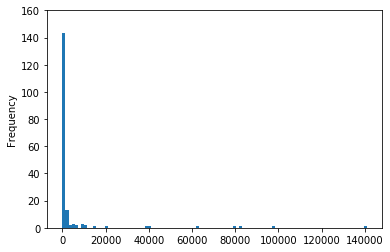

In [21]:
country_day["confirmed"].plot(kind="hist", bins=100, ylim=(0,160))

La distribución general básicamente no aporta información, la inmensa mayoría de los países van iniciando, yo esperaría que después de unos 3-6 meses la distribución esté centrada dentro de los 100 mil o más casos por país por lo menos.

### Misma gráfica con menos cubetas

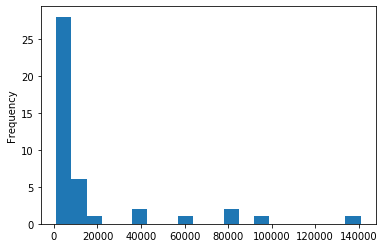

In [22]:
country_day_top["confirmed"].plot(kind="hist", bins=20)

(No hay gran cosa que se le pueda agregar a la anterior)

### Países con menos de 1000 casos

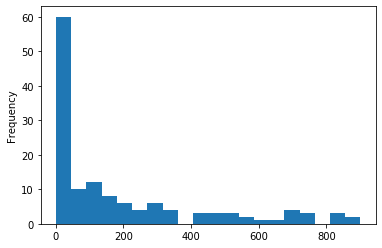

In [23]:
country_day_bottom["confirmed"].plot(kind="hist", bins=20)

Es claro que todavía la mayoría están iniciando, esos 60 países que tienen menos de 50 casos definitivamente van a tener más casos en unos meses.

# Número de casos como línea de tiempo por grupos de países

La siguiente función devuelve 3 gráficas de línea de tiempo para la lista de países con los números de enfermos confirmados, un estimado del número de casos activos y una de decesos registrados. Acepta un argumento que es la lista de nombres de países que se quiere graficar.

In [24]:
def plot_timeline(c_list = ["Mexico"], figsize=(15,5)):
    fig, ax = plt.subplots(1,3, figsize=figsize)
    plt.xticks(rotation=45)
    for c in c_list:
        ax[0].plot(country[c]["2020-01":]["confirmed"], label=c)
        ax[1].plot(country[c]["2020-01":]["confirmed"] - 
                   country[c]["2020-01":]["recovered"] - 
                   country[c]["2020-01":]["deaths"], label=c)
        ax[2].plot(country[c]["2020-01":]["deaths"], label=c, linestyle="-")
        
        ax[0].set_title("Confirmed")
        ax[1].set_title("Active")
        ax[2].set_title("Deaths")
        
    for ax in fig.axes:
        plt.sca(ax)
        plt.xticks(rotation=45)
        plt.legend()

## Mexico / Korea del Sur / Singapur / Suecia
Países que me interesan por su contexto parecido al de México y la esperanza de que tengamos resultados positivos (a diferencia de la mayoría de los países del Top 10, por ejemplo)

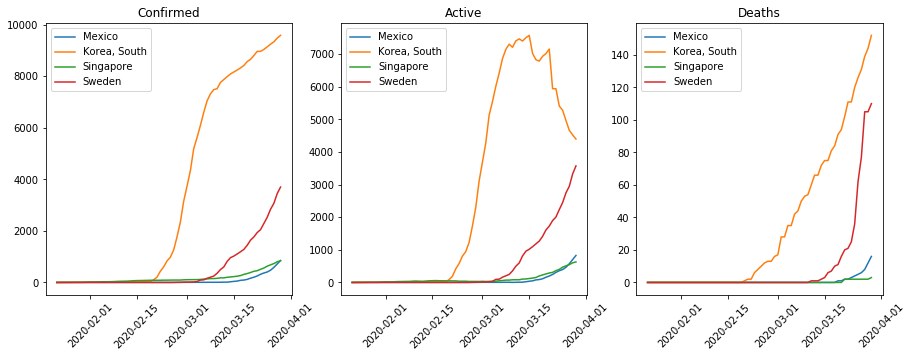

In [25]:
c_list = ["Mexico", "Korea, South", "Singapore", "Sweden"]
plot_timeline(c_list)

## Países  en el top 5 de casos confirmados
Podemos crear listas manualmente, pero para estos casos simplemente podemos usar el DataFrame que tenemos para el último día registrado y simplemente sacar las listas automáticamente.

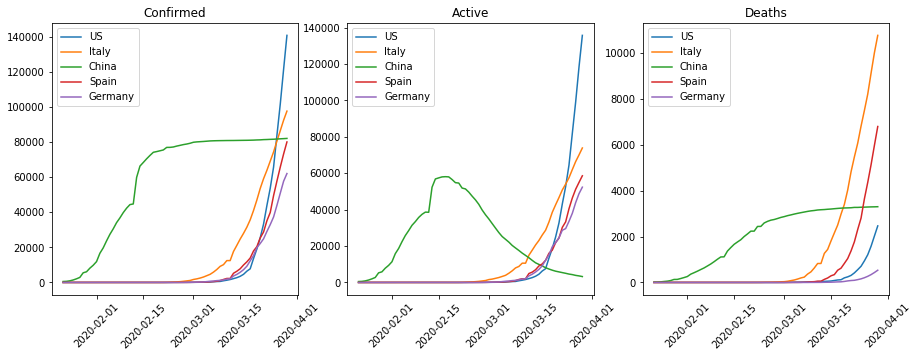

In [26]:
c_list = country_day.sort_values("confirmed", ascending=False).head(5).index
plot_timeline(c_list)

Se podrá decir mucho de China pero es bastante obvio que sus métodos de contención funcionan. Los otros 4 países son de primer mundo, y hasta el momento van mal en mi opinión, Alemania probablemente es el que podría todavía lograr tener un número bajo de muertes, pero no estoy seguro que lo logre.

## Países en el top 6-10 de casos confirmados

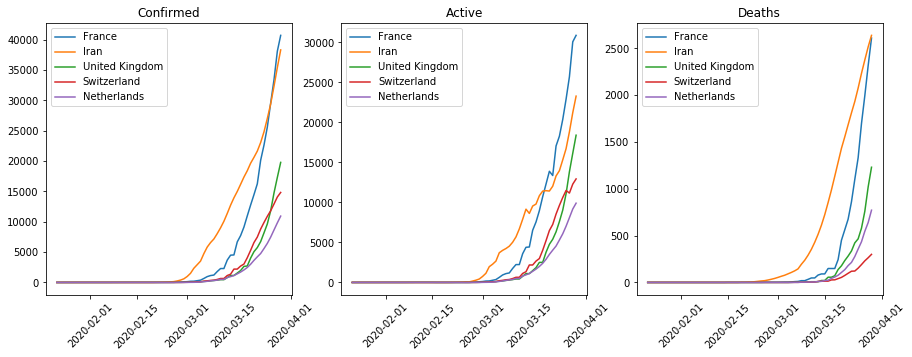

In [27]:
c_list = country_day.sort_values("confirmed", ascending=False).head(10).tail(5).index
plot_timeline(c_list)

La otra mitad del top 10 tampoco se ve bien, Suecia estaba en las miradas por sus buenos resultados, pero por ahí del 24 de marzo su número de casos empezó el aumento y sigue subiendo fuertemente.

## Countries in the top 11-20 confirmed list

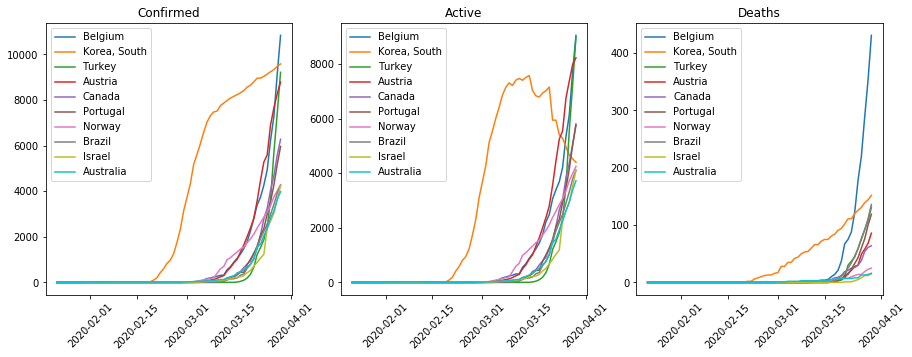

In [28]:
c_list = country_day.sort_values("confirmed", ascending=False).head(20).tail(10).index
plot_timeline(c_list)

Del este grupo Corea del Sur es el único que parece haber superado la etapa difícil (¿la primera?) los demás países parecen apenas ir iniciando algunos de ellos podrían todavía tener números similares a Korea si usan las medidas pertinentes para cada caso, habrá que ver cómo evoluciona esto (hoy es 29 de Marzo del 2020).

## Países con entre 500 y 1000 casos
Hay una distribución amplia de números, pero en general todos van sobre un comportamiento similar, exceptuando el barco "Diamond Princess" que veremos abajo.

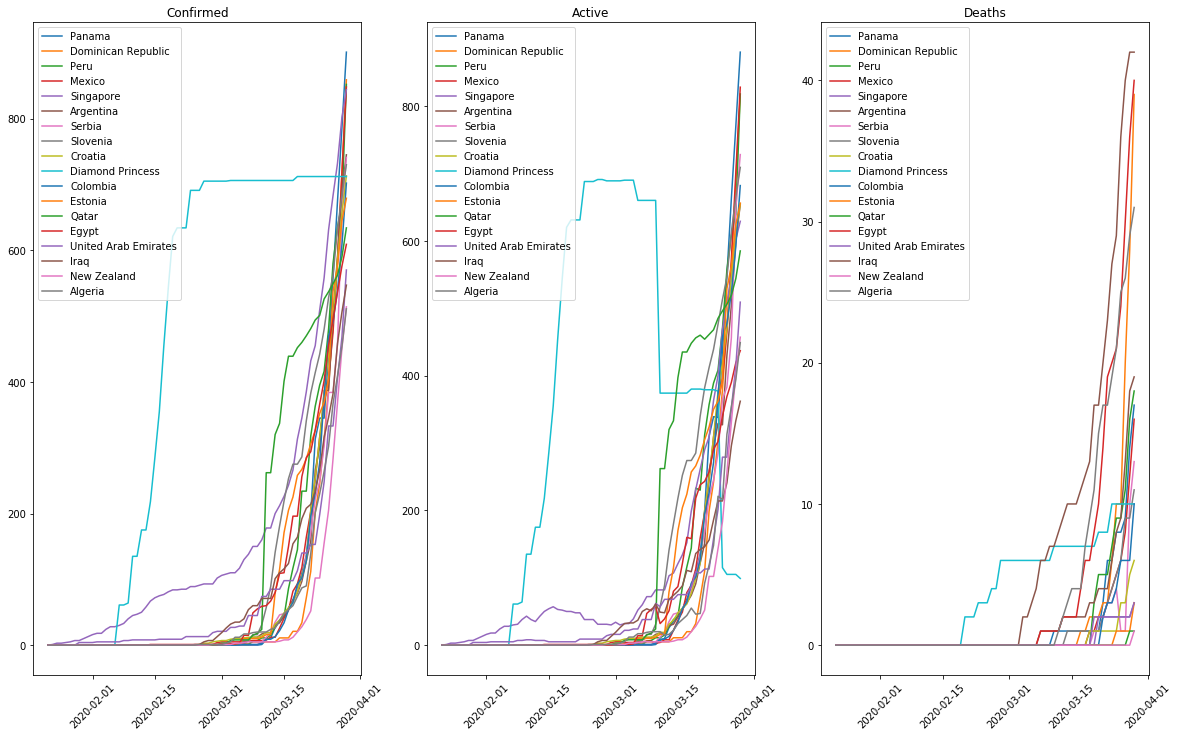

In [29]:
c_list = country_day.query("confirmed > 500 & confirmed < 1000 ").sort_values("confirmed", ascending=False).index
plot_timeline(c_list, figsize=(20,12))

## Diamond Princess 

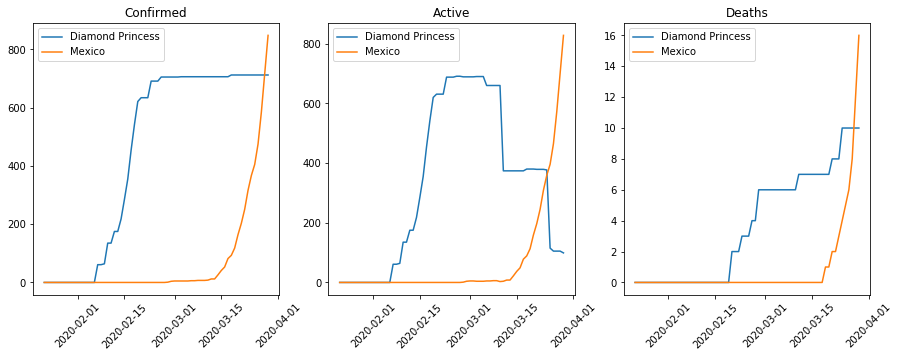

In [30]:
plot_timeline(["Diamond Princess", "Mexico"])

Parece ser que el problema ya está controlado en el crucero, al parecer todavía no empiezan a desembarcar a las personas, pero con 100 casos todavía activos es probable que les tome un poco más de tiempo. México tiene un índice de mortalidad similar al inicio de la fase 2, esperemos que así continúe.

# Datos del país con día-cero normalizado

In [31]:
def get_country(data, country='Mexico', min_cases=0, column="confirmed"):
    data_df = pd.DataFrame(data.json()[country],)
    data_df['date'] = pd.to_datetime(data_df['date'])
    data_df = data_df[data_df["confirmed"] > min_cases ]
    min_sec = time.mktime(data_df['date'].min().timetuple())
    data_df['seconds'] = [time.mktime(t.timetuple()) - min_sec for t in data_df.date]
    data_df['days'] = data_df['seconds'] / 86400
    return data_df[["days", column]].set_index("days")

In [32]:
# Example: Mexico data
mx = get_country(data, country='Mexico')
mx.head()

,confirmed
days,
0.0,1
1.0,4
2.0,5
3.0,5
4.0,5


## Uniendo dataframes normalizados para la lista de países deseada

In [33]:
def merge_country(data, suffixes=["_mx", "_ks"], c_list=["Mexico", "Korea, South"], column="confirmed"):
    if len(c_list) != len(suffixes):
        raise "Both c_list and suffixes need to have same length"
    df = get_country(data, country=c_list.pop(0), column=column)
    s = suffixes.pop(0)
    for i in range(len(c_list)):
        df = pd.merge(df, get_country(data, country=c_list[i], column=column), how="outer", suffixes=[s, suffixes[i]], on="days") #first two
        df.rename(columns={column: "{}{}".format(column, suffixes[i])}, inplace=True) # Rest of them
    return df    

## Subset de países "interesantes"
Los he visto muy mencionados en noticias, seguro en los próximos días y semanas se moverán mucho los países más mencionados al respecto del covid-19.

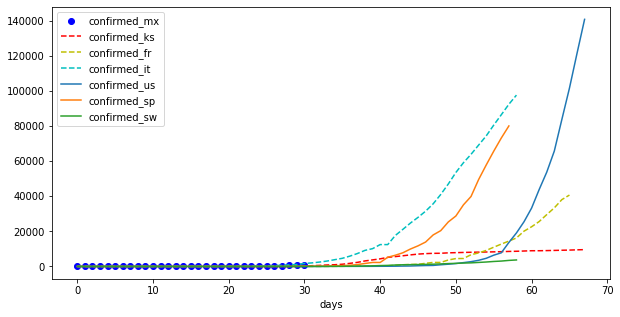

In [34]:
s = ["_mx"    , "_ks"         , "_fr"   , "_it"  , "_us", "_sp"  , "_sw"]
cl = ["Mexico", "Korea, South", "France", "Italy", "US", "Spain", "Sweden"]
cgroup = merge_country(data, suffixes=s, c_list=cl, column="confirmed")
#display(cgroup.tail())
cgroup.plot(figsize=(10,5), style = ['bo','r--','y--', 'c--'])#, xlim=(0,35), ylim=(0,1000))

## Comparando México con Corea del Sur y Suecia

Son los dos países que se ponen como ejemplo en las noticias, Suecia no parece que de pronto saltó de ser el ejemplo a no serlo, pero lo veremos más claro en unos días.

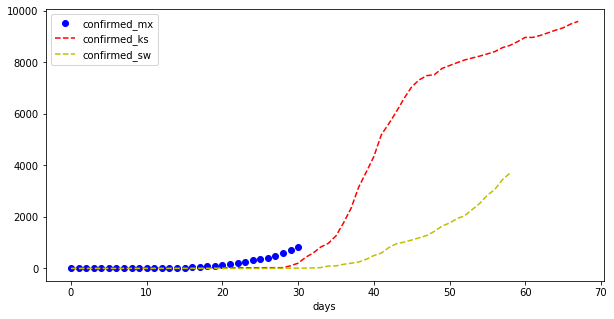

In [35]:
s = ["_mx"    , "_ks"         , "_sw"]
cl = ["Mexico", "Korea, South", "Sweden"]
cgroup = merge_country(data, suffixes=s, c_list=cl, column="confirmed")
cgroup.plot(figsize=(10,5), style = ['bo','r--','y--', 'c--'])#, xlim=(0,35), ylim=(0,1000))

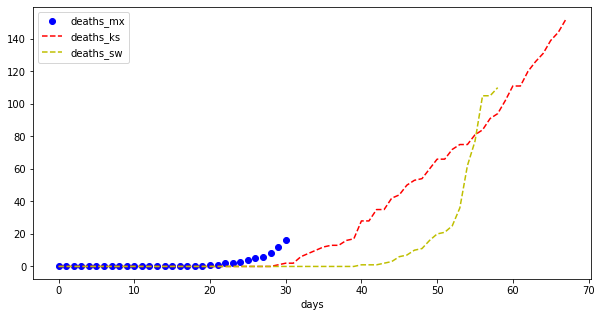

In [36]:
s = ["_mx"    , "_ks"         , "_sw"]
cl = ["Mexico", "Korea, South", "Sweden"]
cgroup = merge_country(data, suffixes=s, c_list=cl, column="deaths")
cgroup.plot(figsize=(10,5), style = ['bo','r--','y--', 'c--'])#, xlim=(0,35), ylim=(0,1000))

## Agregando Singapur como buen ejemplo

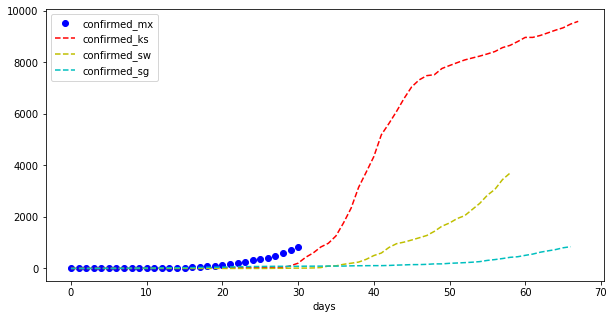

In [37]:
s = ["_mx"    , "_ks"         , "_sw"   , "_sg" ]
cl = ["Mexico", "Korea, South", "Sweden", "Singapore"]
cgroup = merge_country(data, suffixes=s, c_list=cl, column="confirmed")
cgroup.plot(figsize=(10,5), style = ['bo','r--','y--', 'c--'])#, xlim=(0,35), ylim=(0,1000))

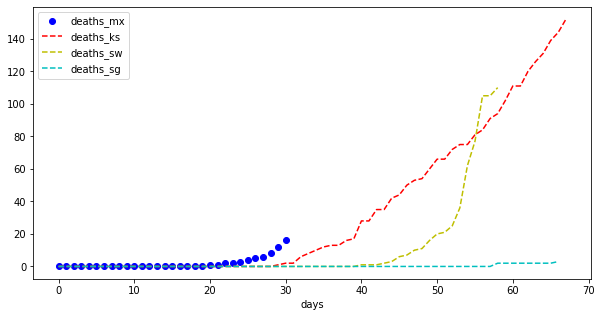

In [38]:
s = ["_mx"    , "_ks"         , "_sw"   , "_sg" ]
cl = ["Mexico", "Korea, South", "Sweden", "Singapore"]
cgroup = merge_country(data, suffixes=s, c_list=cl, column="deaths")
cgroup.plot(figsize=(10,5), style = ['bo','r--','y--', 'c--'])#, xlim=(0,35), ylim=(0,1000))

Definitivamente Singapur va muy bien, ha logrado estar más de 2 meses sin pasar a fase 2. Suecia estuvo cerca pero no lo logró, Corea del Sur tuvo 1 mes en fase 1, y México solo 20-25 días .

# IGNORAR
Jugando con ajustes, no hay nada serio ni explicado

In [39]:
data_df = get_country(data, country="Mexico",column="confirmed")
data_df.head()

,confirmed
days,
0.0,1
1.0,4
2.0,5
3.0,5
4.0,5


(array([ 0.  ,  8.75, 17.5 , 26.25, 35.  ]),
 array([   5.18449198,    4.57574077,   64.64459943,  446.24538736,
        1674.9642656 ]))

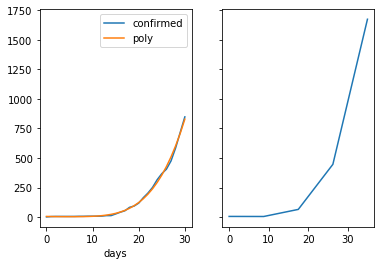

In [40]:
p = np.polyfit(data_df.index.array, data_df["confirmed"].array,4)
x = np.linspace(data_df.index.min(), data_df.index.max(),50)
f = np.poly1d(p)
#plt.figure(1)
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
data_df['poly'] = f(data_df.index)
data_df.plot(y=["confirmed", "poly"], fig=fig, ax = ax1)
x = np.linspace(data_df.index.min(), data_df.index.max()+5,5)
ax2.plot(x, f(x))
x, f(x)

In [ ]:
x_range = data_df.days
y_range = np.log(data_df["confirmed"])

X = sm.add_constant(x_range)
y = y_range
mods = sm.OLS(y, X)

In [42]:
res = mods.fit()
#res.summary()

In [ ]:
a, b = res.params
# Cuchareo
#a = 0.30
#b = 0.23
#c = 1
y = lambda x: np.exp(a) * np.exp(b) ** x

x_future = np.linspace(data_df.days.min(), data_df.days.max()+5, len(data_df.days))

plt.plot(x_future, y(x_future), 'r-')
#plt.plot(data_df.days, y(data_df.days), 'g-')
plt.plot(data_df.days, data_df['confirmed'], 'b-')